In [1]:
import numpy as np
if not hasattr(np, 'longfloat'):
    np.longfloat = np.float64
import serpentTools as st
from pathlib import Path
from numpy.linalg import norm
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd

# Multiplication Factor Convergence

In [4]:
current_dir = Path.cwd()
print(current_dir)
# his_rel_path = Path('standard_conditions/s82d_ac_c3_gcu_ringres.main_his0.m')
# hisRes = st.read((current_dir/his_rel_path).resolve())

c:\Users\Sam\Documents\SNAP-REACTORS-PRIVATE\snapReactors


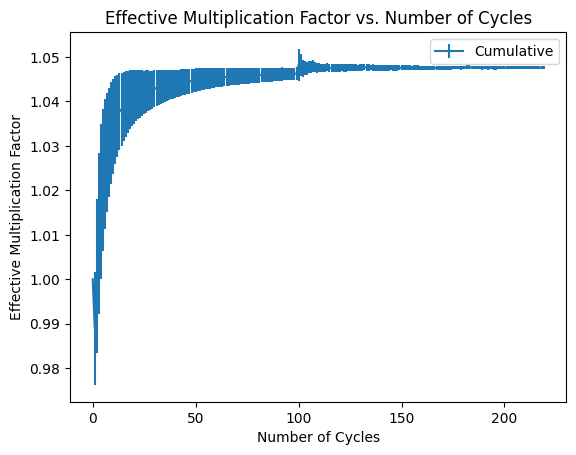

In [ ]:
# hKeff = hisRes['anaKeff']
# hKu = hKeff[:, 2] * 3 * hKeff[:, 1]
# cyc = np.arange(hKu.shape[0])
# plt.title("Effective Multiplication Factor vs. Number of Cycles")
# plt.xlabel("Number of Cycles")
# plt.ylabel("Effective Multiplication Factor")
# plt.errorbar(cyc, hKeff[:, 1], yerr=hKu, label="Cumulative")
# plt.legend()

# Depletion Comparison

SERPENT Serpent 2.2.1 found in C:\Users\Sam\Documents\SNAP-REACTORS-PRIVATE\snapReactors\reactor_models\Wet_Experiment_Models\burned_XS\s82d_ac_c3_gcu_ringres.main_res.m, but version 2.1.31 is defined in settings
  Attempting to read anyway. Please report strange behaviors/failures to developers.


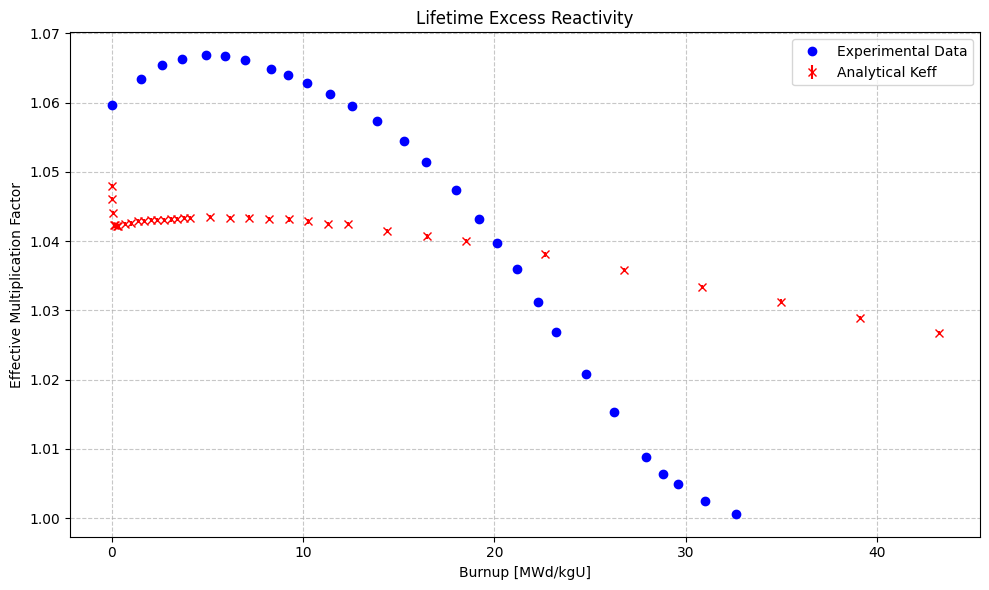

In [16]:
burn_rel_path = Path('burned_XS/s82d_ac_c3_gcu_ringres.main_res.m')
burnRes = st.read('C:\\Users\\Sam\\Documents\\SNAP-REACTORS-PRIVATE\\snapReactors\\reactor_models\\Wet_Experiment_Models\\burned_XS\\s82d_ac_c3_gcu_ringres.main_res.m')#(current_dir/burn_rel_path).resolve())
exp_rel_path = Path('burned_XS/burn-data.csv')
exp_path = (current_dir/exp_rel_path).resolve()
exp_data = pd.read_csv('C:\\Users\\Sam\\Documents\\SNAP-REACTORS-PRIVATE\\snapReactors\\reactor_models\\Wet_Experiment_Models\\burned_XS\\burn-data.csv')#exp_path)
x_data = exp_data['x (MWd/kgU)'].values
y_data = exp_data['y(k)'].values

dep = st.read('C:\\Users\\Sam\\Documents\\SNAP-REACTORS-PRIVATE\\snapReactors\\reactor_models\\Wet_Experiment_Models\\burned_XS\\s82d_ac_c3_gcu_ringres.main_dep.m')
res = burnRes
anaKeff = res['impKeff']
anaKeff_val = anaKeff[:,0]
anaKeff_err = 3*anaKeff[:,1]
anaKeff_err = np.multiply(anaKeff_err, anaKeff_val)
burnup = dep.burnup


# Create the plot
plt.figure(figsize=(10, 6))
plt.title("Lifetime Excess Reactivity")
plt.xlabel("Burnup [MWd/kgU]")
plt.ylabel("Effective Multiplication Factor")

# Plot experimental data
plt.errorbar(x_data, y_data, yerr=None, fmt='o', label="Experimental Data", color='blue')

# Plot analytical Keff data
plt.errorbar(burnup, anaKeff_val, yerr=anaKeff_err, fmt='x', label="Analytical Keff", color='red')

plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
